# Ejercicio 2

In [1]:
import numpy as np
import scipy.io as scio
import scipy.signal as scs
import matplotlib.pyplot as plt
import spectrum
from IPython.display import Audio

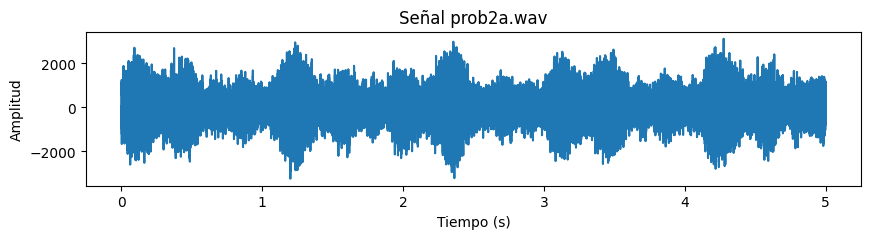

In [2]:
fs_a, x_a = scio.wavfile.read('prob2a.wav')
x_a = x_a.astype('float64')
t_a = (1/fs_a)*np.arange(x_a.size)
plt.figure(figsize=(10,2))
plt.plot(t_a, x_a)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal prob2a.wav')
plt.show()
Audio(x_a, rate=fs_a)

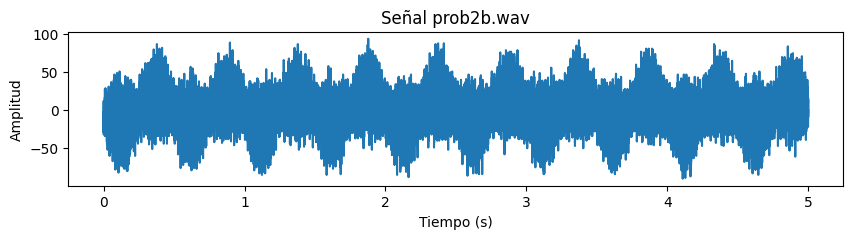

In [3]:
fs_b, x_b = scio.wavfile.read('prob2b.wav')
x_b = x_b.astype('float64')
t_b = (1/fs_b)*np.arange(x_b.size)
plt.figure(figsize=(10,2))
plt.plot(t_b, x_b)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal prob2b.wav')
plt.show()
Audio(x_b, rate=fs_b)

## a) $\hat{S}_{xx}(\omega)$ con método no paramétrico

In [4]:
f_a, Pp_a = scs.periodogram(x_a, fs=fs_a)
f_b, Pp_b = scs.periodogram(x_b, fs=fs_b)

fig, axs = plt.subplots(2,1,figsize=(10,10))

axs[0].plot(f_a, 20*np.log10(Pp_a))
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('PSD (dB)')
axs[0].set_ylim((-100,150))
axs[0].set_title('Periodograma prob2a.wav')

axs[1].plot(f_b, 20*np.log10(Pp_b))
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('PSD (dB)')
axs[1].set_ylim((-100,80))
axs[1].set_title('Periodograma prob2b.wav')
plt.show()

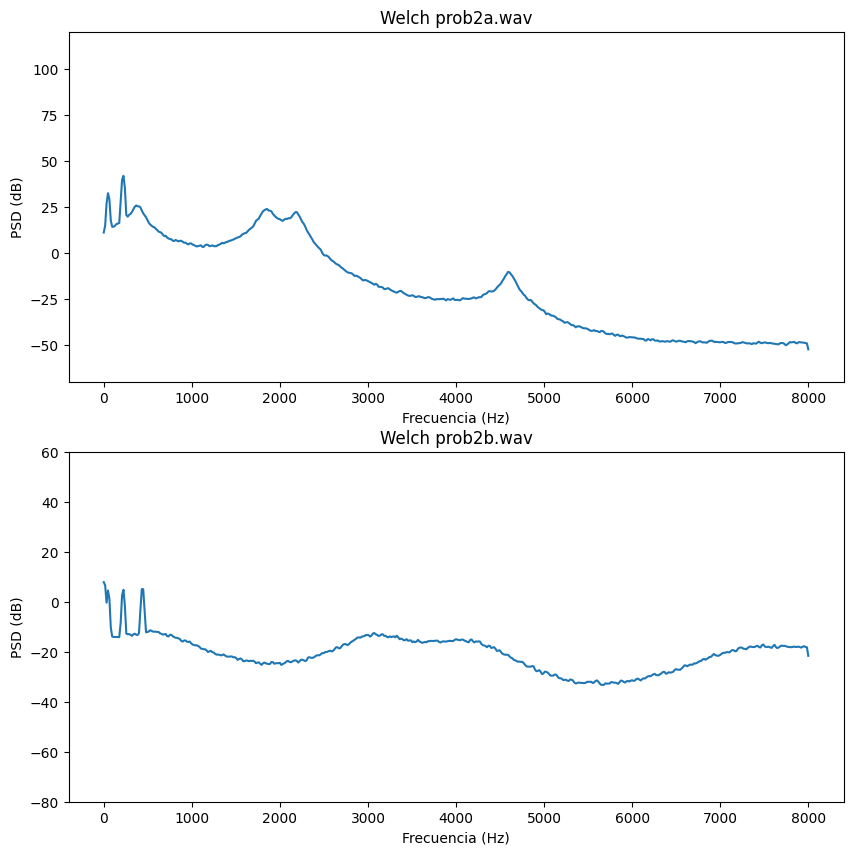

In [5]:
K = (80, 80)
L = (x_a.size//K[0], x_b.size//K[1])
D = (L[0]//2, L[1]//2)
window = ('blackman', 'blackman')
f_a, Pw_a = scs.welch(x_a, fs=fs_a, window=window[0], nperseg=L[0], noverlap=D[0], detrend=None)
f_b, Pw_b = scs.welch(x_b, fs=fs_b, window=window[1], nperseg=L[1], noverlap=D[1], detrend=None)

fig, axs = plt.subplots(2,1,figsize=(10,10))

axs[0].plot(f_a, 10*np.log10(Pw_a))
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('PSD (dB)')
axs[0].set_ylim((-70,120))
axs[0].set_title('Welch prob2a.wav')

axs[1].plot(f_b, 10*np.log10(Pw_b))
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('PSD (dB)')
axs[1].set_ylim((-80,60))
axs[1].set_title('Welch prob2b.wav')
plt.show()

In [6]:
def correlation(x, order):
    assert order < x.size, 'lag must be less than len(x)'

    invN = 1.0 / x.size
    r = np.zeros(order+1, dtype=float)
    r[0] = np.sum(x * x) * invN

    for k in range(1, order+1):
        r[k] = np.sum(x[k:] * x[0:x.size-k]) * invN

    return r

def aryule(X, order):
    r = correlation(X, order)
    A, P, k = spectrum.LEVINSON(r, allow_singularity=True)
    return A, P, k

In [7]:
import numba as nb

@nb.njit('(float64[::1],)', fastmath=True)
def levinsonP(r):
    A = np.zeros(r.size - 1)
    P = r[0]

    if r.size > 1:
        save = r[1]
        temp = -save / P
        P *= 1.0 - temp * temp
        A[0] = temp

    for k in range(1, r.size - 1):
        save = r[k+1]
        for j in range(0, k):
            save += A[j] * r[k-j]
        temp = -save / P
        P *= 1.0 - temp * temp
        A[k] = temp

        khalf = (k+1) // 2
        for j in range(0, khalf):
            kj = k-j-1
            save = A[j]
            A[j] = save + temp * A[kj]
            if j != kj:
                A[kj] += temp*save

    return P

def multiAryuleP(X, orders):
    maxOrder = np.max(orders)
    r = correlation(X, maxOrder)
    rho = np.empty(orders.size)
    for i in range(orders.size):
        rho[i] = levinsonP(r[:orders[i]+1])
    return rho

In [8]:
order = np.arange(1, 1001)
rhos = [multiAryuleP(x_a, order), multiAryuleP(x_b, order)]

In [9]:
criteria = {'AIC': spectrum.AIC, 'AICc': spectrum.AICc, 'KIC': spectrum.KIC, 'AKICc': spectrum.AKICc,
            'FPE': spectrum.FPE, 'MDL': spectrum.MDL, 'CAT': spectrum.CAT}
optimums = [{}, {}]
Ns = [x_a.size, x_b.size]

for crit in criteria:
    for i in range(2):
        cost = criteria[crit](Ns[i], rhos[i], order)
        optimums[i][crit] = order[np.argmin(cost)]

print(optimums[0], '\n', optimums[1])

{'AIC': 356, 'AICc': 356, 'KIC': 197, 'AKICc': 197, 'FPE': 356, 'MDL': 197, 'CAT': 356} 
 {'AIC': 816, 'AICc': 816, 'KIC': 508, 'AKICc': 508, 'FPE': 816, 'MDL': 227, 'CAT': 816}


## c) Gráficos de los espectros $\hat{S}_{xx}(\omega)$ paramétricos

[]

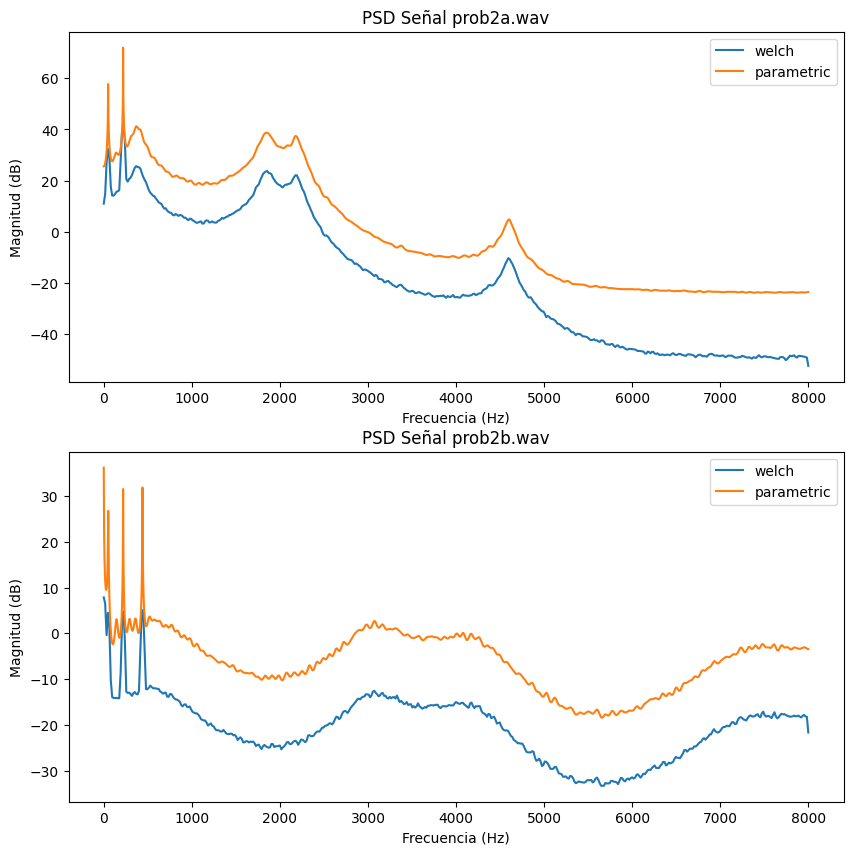

In [12]:
pa = spectrum.pyule(x_a, optimums[0]['MDL'], NFFT=Ns[0], sampling=fs_a)
pb = spectrum.pyule(x_b, optimums[1]['MDL'], NFFT=Ns[1], sampling=fs_b)
Pa = pa._getPSD(); Pb = pb._getPSD()
Fa = np.array(pa.frequencies(sides='onesided')); Fb = np.array(pb.frequencies(sides='onesided'))

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10))

ax1.plot(f_a, 10*np.log10(Pw_a), label='welch')
ax1.plot(Fa, 10*np.log10(Pa), label='parametric')
ax1.legend()
ax1.set_title('PSD Señal prob2a.wav')
ax1.set_xlabel('Frecuencia (Hz)')
ax1.set_ylabel('Magnitud (dB)')

ax2.plot(f_b, 10*np.log10(Pw_b), label='welch')
ax2.plot(Fb, 10*np.log10(Pb), label='parametric')
ax2.legend()
ax2.set_title('PSD Señal prob2b.wav')
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Magnitud (dB)')
plt.plot()


## d) 10 × p polos y 10 × q ceros

[]

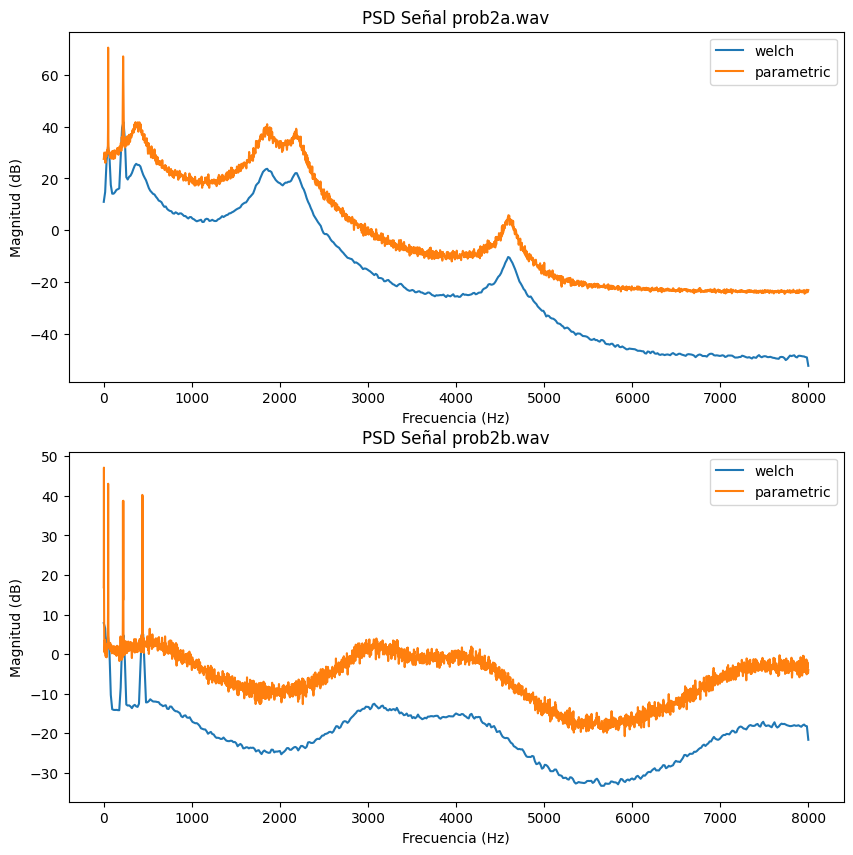

In [13]:
pa = spectrum.pyule(x_a, 10*optimums[0]['MDL'], NFFT=Ns[0], sampling=fs_a)
pb = spectrum.pyule(x_b, 10*optimums[1]['MDL'], NFFT=Ns[1], sampling=fs_b)
Pa = pa._getPSD(); Pb = pb._getPSD()
Fa = np.array(pa.frequencies(sides='onesided')); Fb = np.array(pb.frequencies(sides='onesided'))

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10))

ax1.plot(f_a, 10*np.log10(Pw_a), label='welch')
ax1.plot(Fa, 10*np.log10(Pa), label='parametric')
ax1.legend()
ax1.set_title('PSD Señal prob2a.wav')
ax1.set_xlabel('Frecuencia (Hz)')
ax1.set_ylabel('Magnitud (dB)')

ax2.plot(f_b, 10*np.log10(Pw_b), label='welch')
ax2.plot(Fb, 10*np.log10(Pb), label='parametric')
ax2.legend()
ax2.set_title('PSD Señal prob2b.wav')
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Magnitud (dB)')
plt.plot()

Créditos a Jérôme Richard por el código optimizado de las funciones: **_correlation_**, **_aryule_**, **_levinsonP_** y **_multiAryuleP_**, provisto en [stackoverflow](https://stackoverflow.com/questions/74410243/how-can-i-speed-up-this-python-code-with-parallel-processing/74413613#74413613)